Some of the contents of this notebook were prepared by Dr. Edward Raff (Spring 2019), and some content were borrowed from https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-05-09-Clustering-with-Scikit-with-GIFs.ipynb

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from sklearn.metrics import v_measure_score, completeness_score, homogeneity_score
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph

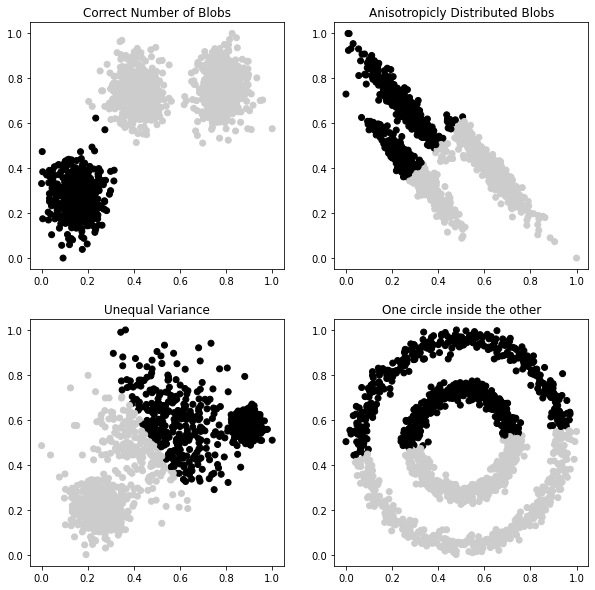

In [3]:
#Example from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py 

def plot_2d_examples(cluster_model):
  plt.figure(figsize=(10, 10))

  n_samples = 1500
  random_state = 170
  X, y = make_blobs(n_samples=n_samples, random_state=random_state)
  #print(X.shape)
  #print(y.shape)
  X = MinMaxScaler().fit_transform(X)

  ## Correct number of clusters
  y_pred = cluster_model.fit_predict(X)

  plt.subplot(221)
  plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap=plt.cm.nipy_spectral)
  plt.title("Correct Number of Blobs")

  ## Anisotropicly distributed data
  transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
  X_aniso = np.dot(X, transformation)
  X_aniso = MinMaxScaler().fit_transform(X_aniso)
  y_pred = cluster_model.fit_predict(X_aniso)  # we run clustering algorithm

  plt.subplot(222)
  plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred, cmap=plt.cm.nipy_spectral)
  plt.title("Anisotropicly Distributed Blobs")

  ## Different variance
  X_varied, y_varied = make_blobs(n_samples=n_samples,
                                  cluster_std=[1.0, 2.5, 0.5],
                                  random_state=random_state)

  #dataset2 = datasets.make_circles(n_samples=1000, factor=.5, noise=.05)[0]
  X_varied = MinMaxScaler().fit_transform(X_varied)
  y_pred = cluster_model.fit_predict(X_varied)  # we run clustering algorithm

  plt.subplot(223)
  plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred, cmap=plt.cm.nipy_spectral)
  plt.title("Unequal Variance")

  ## Unevenly sized blobs
  #X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
  #X_filtered = MinMaxScaler().fit_transform(X_filtered)
  #y_pred = cluster_model.fit_predict(X_filtered) # we run clustering algorithm

  #plt.subplot(224)
  #plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred, cmap=plt.cm.nipy_spectral)
  #plt.title("Unevenly Sized Blobs")

  # One circle inside the other
  X_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)[0]
  X_circles = MinMaxScaler().fit_transform(X_circles)
  y_pred = cluster_model.fit_predict(X_circles) # we run clustering algorithm
  
  plt.subplot(224)
  plt.scatter(X_circles[:, 0], X_circles[:, 1], c=y_pred, cmap=plt.cm.nipy_spectral)
  plt.title("One circle inside the other")

  plt.show()
  
plot_2d_examples(KMeans(n_clusters=2))

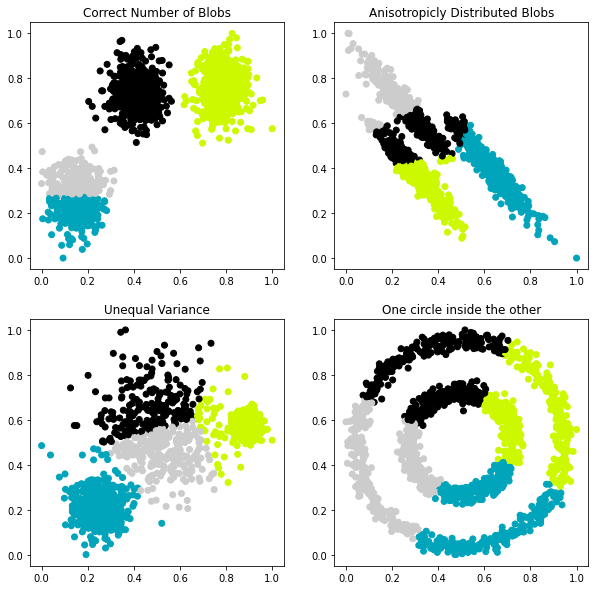

In [4]:
plot_2d_examples(KMeans(n_clusters=4))

The biggest issue is determining what number of clusters $k$ to search for!  But as use see above, even we enter correct $k$, certain types of shapes are simply not amenable to k-means clustering. We will see other methods to deal with those *unexpected* shapes.

## Elbow method:

A common approach to find a proper $k$ is called the *elbow* method. What you do: evaluate k-means for every value of $k$ you are interested in. Compute the k-means objective function for each value of $k$ (it has an associated score method that will do this). Plot it out, and look for the position in the plot where the score stops improving as much with an increase in $k$. This point would often (hopefully) look like an "elbow". 


In [5]:
#Let's form a 4-cluster dataset with 1000 points in each
np.random.seed(844)
clust1 = np.random.normal(5, 2, (1000,2))
clust2 = np.random.normal(15, 3, (1000,2))
clust3 = np.random.multivariate_normal([17,3], [[1,0],[0,1]], 1000)
clust4 = np.random.multivariate_normal([2,16], [[1,0],[0,1]], 1000)
dataset1 = np.concatenate((clust1, clust2, clust3, clust4))
print(dataset1.shape)

(4000, 2)


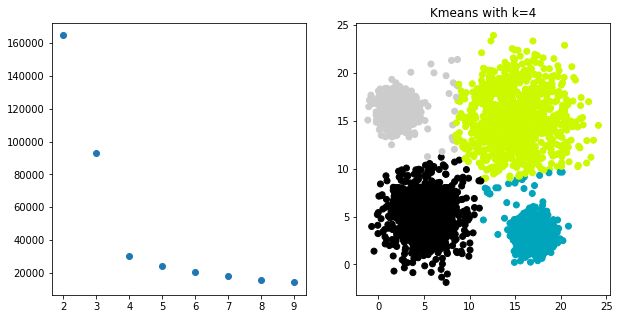

In [6]:
scores = []

for k in range(2, 10):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(dataset1)
  scores.append( -kmeans.score(dataset1) )
  
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot([k for k in range(2,10)], scores, 'o')

n_clusters=4
y_pred = KMeans(n_clusters=n_clusters).fit_predict(dataset1)

plt.subplot(122)
plt.scatter(dataset1[:, 0], dataset1[:, 1], c=y_pred, cmap=plt.cm.nipy_spectral)
plt.title("Kmeans with k=" + str(n_clusters))

plt.show()


## DBSCAN
Density-based spatial clustering of applications with noise (DBSCAN) is a density based clustering algorithm that can neatly handle noise (the clue is in the name). Clusters are considered zones that are sufficiently dense. Points that lack neighbours belonging to any cluster are classifed as noise (a state that is not attainable with K-means or Hierarchical Clustering). 

DBSCAN doesn't require the user to specify the number of clusters. However, the user must define the minimum number of observations that constitutes a cluster (minPts) and the size (radius) of the neighbourhoods (epsilon- often denoted as eps or $\epsilon$). 

In simple terms, DBSCAN identifies clusters and then expands them by searching neighbourhoods. Once all neighbourhoods have been exhausted, the process repeats with a new cluster, until all observations belong to a segment or have been classified as noise.

In [7]:
# we take the first array as the second array has the cluster labels
dataset2 = datasets.make_circles(n_samples=1000, factor=.5, noise=.05)[0]

Dataset1:
Number of Noise Points: 47 (4000)
Dataset2:
Number of Noise Points: 1 (1000)


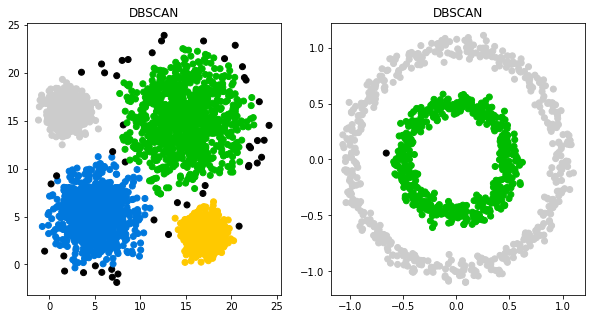

In [8]:
# implementing DBSCAN
dbscan_dataset1 = cluster.DBSCAN(eps=1.0, min_samples=5, metric='euclidean').fit_predict(dataset1)

dbscan_dataset2 = cluster.DBSCAN(eps=0.1, min_samples=5, metric='euclidean').fit_predict(dataset2)

# noise points are assigned -1
print('Dataset1:')
print("Number of Noise Points: ",sum(dbscan_dataset1==-1)," (",len(dbscan_dataset1),")",sep='')
print('Dataset2:')
print("Number of Noise Points: ",sum(dbscan_dataset2==-1)," (",len(dbscan_dataset2),")",sep='')
#cluster_plots(dataset1, dataset2, dbscan_dataset1, dbscan_dataset2)

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.scatter(dataset1[:, 0], dataset1[:, 1], c=dbscan_dataset1, cmap=plt.cm.nipy_spectral)
plt.title("DBSCAN")

plt.subplot(122)
plt.scatter(dataset2[:, 0], dataset2[:, 1], c=dbscan_dataset2, cmap=plt.cm.nipy_spectral)
plt.title("DBSCAN")

plt.show()

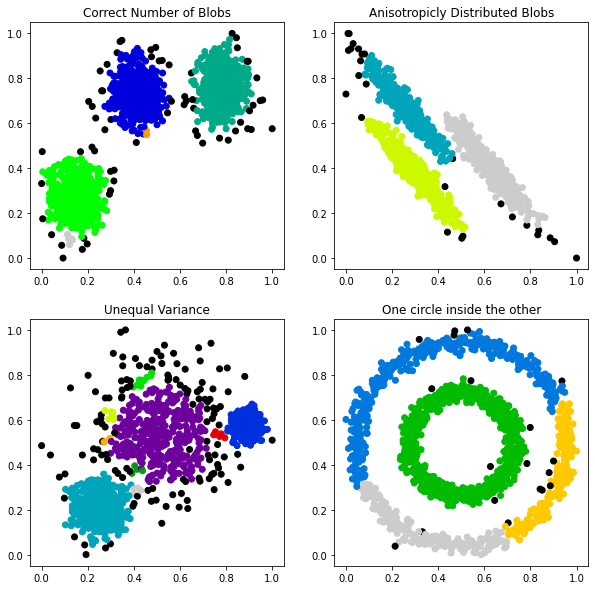

In [9]:
plot_2d_examples(cluster.DBSCAN(eps=0.03, min_samples=5, metric='euclidean'))

# Hierarchical Clustering

First the code needed to plot a dendogram:

In [10]:
#Stolen with love from https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    #Make the coloring match up with the # of clusters
    kwargs['color_threshold'] = max(linkage_matrix[:,2]) - np.max(model.labels_)+1

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

Then, our first trial will be on Iris data.

In [11]:
data = datasets.load_iris()

In [12]:
iris_df = pd.DataFrame(data=np.c_[data['data'], data['target']],columns= list(data['feature_names']) + ['target'])

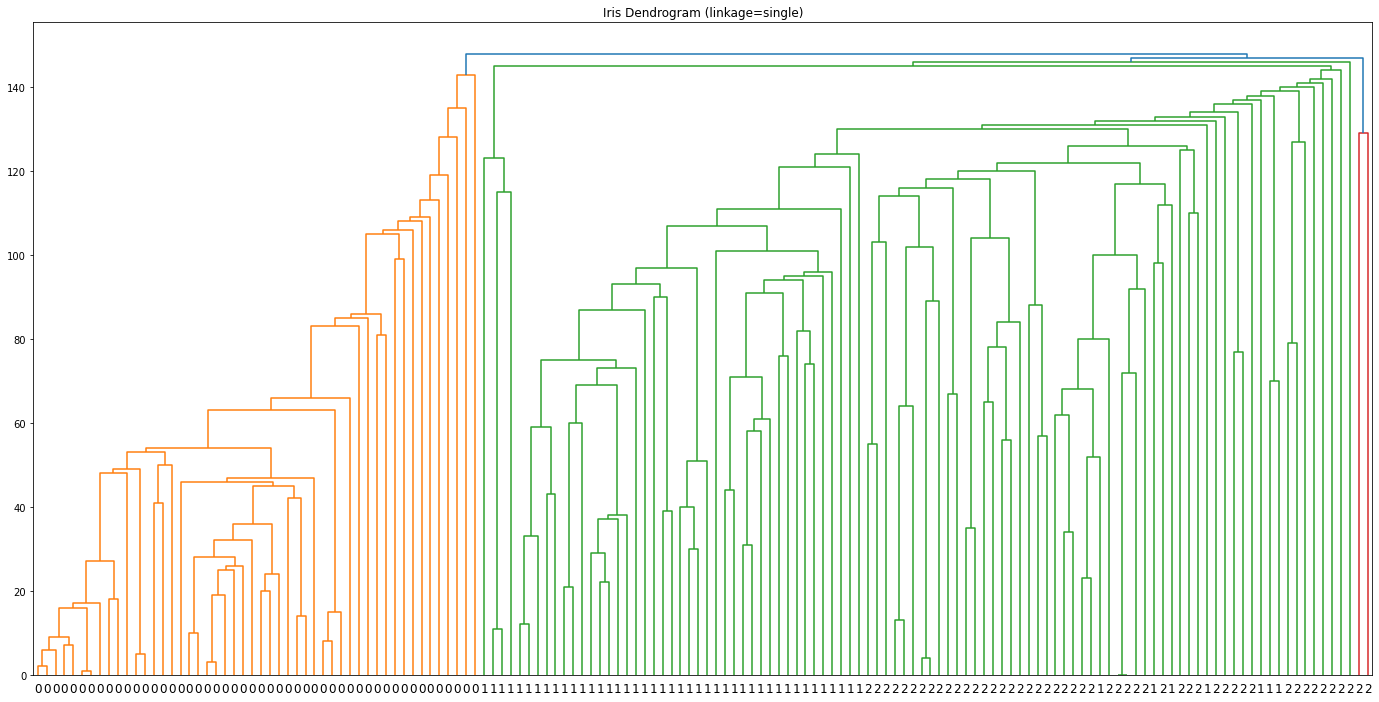

In [13]:
model = AgglomerativeClustering(n_clusters=3, linkage="single") #corresponds to MIN cluster distance criterion

model = model.fit(iris_df.drop('target',axis=1))
plt.figure(figsize=(12*2, 12))
plt.title('Iris Dendrogram (linkage=single)')

plot_dendrogram(model, labels=data['target'], leaf_font_size=12, leaf_rotation=0)
plt.show()

Below the dendogram you see actual class labels. So this clustering does not seem to match with actual classes. Below there are some performance measures. We will come to those soon.

In [14]:
print(model.labels_)
print("Homogeneity", homogeneity_score(data['target'], model.labels_) ) 
print("Completeness", completeness_score(data['target'], model.labels_) ) 
print("V-Score",     v_measure_score(data['target'], model.labels_) ) 

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
Homogeneity 0.5879164116696249
Completeness 0.9202400768446993
V-Score 0.7174643320814477


Hierarchical clustering needs a metric to measure intercluster similarity. In scikit-learn this is parameterized with '*linkage*'.

In [15]:
help(AgglomerativeClustering)
#The linkage criterion determines which distance to use between sets of observation. 
#The algorithm will merge the pairs of cluster that minimize this criterion.
# - 'ward' uses the variance of the clusters being merged.
# - 'average' uses the average of the distances of each observation of the two sets.
# - 'complete' uses the maximum of the distances between all observations of the two sets.
# - 'single' uses the minimum of the distances between all observations of the two sets.

Help on class AgglomerativeClustering in module sklearn.cluster._agglomerative:

class AgglomerativeClustering(sklearn.base.ClusterMixin, sklearn.base.BaseEstimator)
 |  AgglomerativeClustering(n_clusters=2, *, affinity='euclidean', memory=None, connectivity=None, compute_full_tree='auto', linkage='ward', distance_threshold=None, compute_distances=False)
 |  
 |  Agglomerative Clustering.
 |  
 |  Recursively merges pair of clusters of sample data; uses linkage distance.
 |  
 |  Read more in the :ref:`User Guide <hierarchical_clustering>`.
 |  
 |  Parameters
 |  ----------
 |  n_clusters : int or None, default=2
 |      The number of clusters to find. It must be ``None`` if
 |      ``distance_threshold`` is not ``None``.
 |  
 |  affinity : str or callable, default='euclidean'
 |      Metric used to compute the linkage. Can be "euclidean", "l1", "l2",
 |      "manhattan", "cosine", or "precomputed".
 |      If linkage is "ward", only "euclidean" is accepted.
 |      If "precomputed",

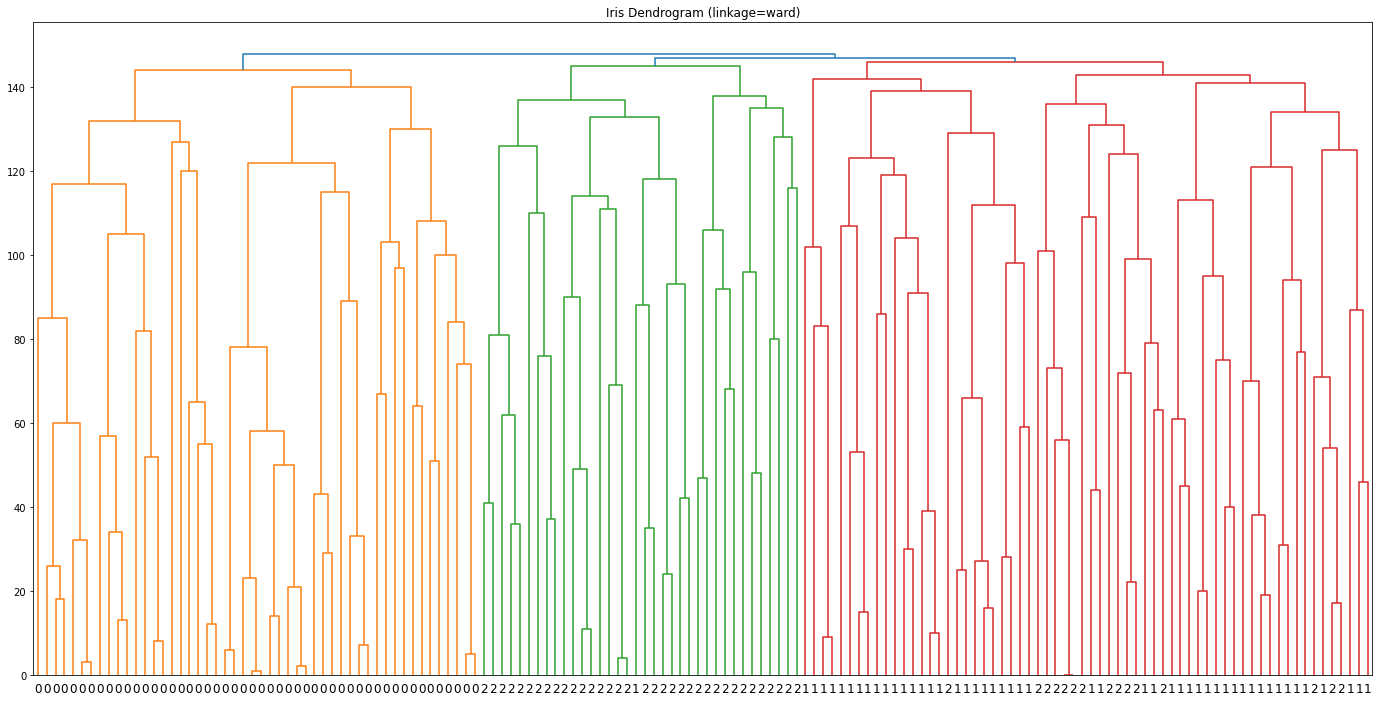

In [16]:
model = AgglomerativeClustering(n_clusters=3, linkage="ward")

model = model.fit(iris_df.drop('target',axis=1))
plt.figure(figsize=(12*2, 12))
plt.title('Iris Dendrogram (linkage=ward)')

plot_dendrogram(model, labels=data['target'], leaf_font_size=12, leaf_rotation=0)
plt.show()

In [17]:
print(model.labels_)
print("Homogeneity", homogeneity_score(data['target'], model.labels_) ) 
print("Completeness", completeness_score(data['target'], model.labels_) ) 
print("V-Score",     v_measure_score(data['target'], model.labels_) ) 

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 0 2 2 2 2
 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 0 0 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0]
Homogeneity 0.7608008469718723
Completeness 0.7795958005591144
V-Score 0.7700836616487869


Differently, for Iris data, we've clustered some data that the class labels are known. We can use this as a way of evaluating the clustering.

For our evaluations, we will look at three measures. Homogeneity, Completeness, and the "V"-Score. 

Homogeneity wants clusters to be homogeneous, which basically means "of the same type". 

Completeness has a different goal. We want all examples from a given class to occur in as few clusters as possible. 

Both of these are desirable properties. Thus, V-Score is the harmonic mean of these two values.

In [18]:
help(homogeneity_score)
#A clustering result satisfies homogeneity if all of its clusters contain
#only data points which are members of a single class.

Help on function homogeneity_score in module sklearn.metrics.cluster._supervised:

homogeneity_score(labels_true, labels_pred)
    Homogeneity metric of a cluster labeling given a ground truth.
    
    A clustering result satisfies homogeneity if all of its clusters
    contain only data points which are members of a single class.
    
    This metric is independent of the absolute values of the labels:
    a permutation of the class or cluster label values won't change the
    score value in any way.
    
    This metric is not symmetric: switching ``label_true`` with ``label_pred``
    will return the :func:`completeness_score` which will be different in
    general.
    
    Read more in the :ref:`User Guide <homogeneity_completeness>`.
    
    Parameters
    ----------
    labels_true : int array, shape = [n_samples]
        ground truth class labels to be used as a reference
    
    labels_pred : array-like of shape (n_samples,)
        cluster labels to evaluate
    
    Retur

In [19]:
help(completeness_score)
#A clustering result satisfies completeness if all the data points
#that are members of a given class are elements of the same cluster.

Help on function completeness_score in module sklearn.metrics.cluster._supervised:

completeness_score(labels_true, labels_pred)
    Completeness metric of a cluster labeling given a ground truth.
    
    A clustering result satisfies completeness if all the data points
    that are members of a given class are elements of the same cluster.
    
    This metric is independent of the absolute values of the labels:
    a permutation of the class or cluster label values won't change the
    score value in any way.
    
    This metric is not symmetric: switching ``label_true`` with ``label_pred``
    will return the :func:`homogeneity_score` which will be different in
    general.
    
    Read more in the :ref:`User Guide <homogeneity_completeness>`.
    
    Parameters
    ----------
    labels_true : int array, shape = [n_samples]
        ground truth class labels to be used as a reference
    
    labels_pred : array-like of shape (n_samples,)
        cluster labels to evaluate
    


In [20]:
help(v_measure_score)
# The V-measure is the harmonic mean between homogeneity and completeness:
#    v = (1 + beta) * homogeneity * completeness
#         / (beta * homogeneity + completeness)    

Help on function v_measure_score in module sklearn.metrics.cluster._supervised:

v_measure_score(labels_true, labels_pred, *, beta=1.0)
    V-measure cluster labeling given a ground truth.
    
    This score is identical to :func:`normalized_mutual_info_score` with
    the ``'arithmetic'`` option for averaging.
    
    The V-measure is the harmonic mean between homogeneity and completeness::
    
        v = (1 + beta) * homogeneity * completeness
             / (beta * homogeneity + completeness)
    
    This metric is independent of the absolute values of the labels:
    a permutation of the class or cluster label values won't change the
    score value in any way.
    
    This metric is furthermore symmetric: switching ``label_true`` with
    ``label_pred`` will return the same score value. This can be useful to
    measure the agreement of two independent label assignments strategies
    on the same dataset when the real ground truth is not known.
    
    
    Read more in the

Last clustering we did (with linkage=ward) did pretty well with 0.76, 0.78 and 0.77 Homogeneity, Completeness and V-score respectively. Lets see how these values change for some bad clusterings:

In [21]:
#What if we assigned every data point to its own cluster?
bad_assignment = [i for i in range(iris_df.shape[0])]

print("Homogeneity", homogeneity_score(data['target'], bad_assignment) ) 
print("Completeness", completeness_score(data['target'], bad_assignment) ) 
print("V-Score",     v_measure_score(data['target'], bad_assignment) ) 

Homogeneity 1.0000000000000004
Completeness 0.21925608713979686
V-Score 0.3596555136405196


In [22]:
#What if we assigned every point to one massive cluster?
bad_assignment = [0 for i in range(iris_df.shape[0])]
print("Homogeneity", homogeneity_score(data['target'], bad_assignment) ) 
print("Completeness", completeness_score(data['target'], bad_assignment) ) 
print("V-Score",     v_measure_score(data['target'], bad_assignment) ) 

Homogeneity 0.0
Completeness 1.0
V-Score 0.0


## Agglomerative clustering on toy datasets

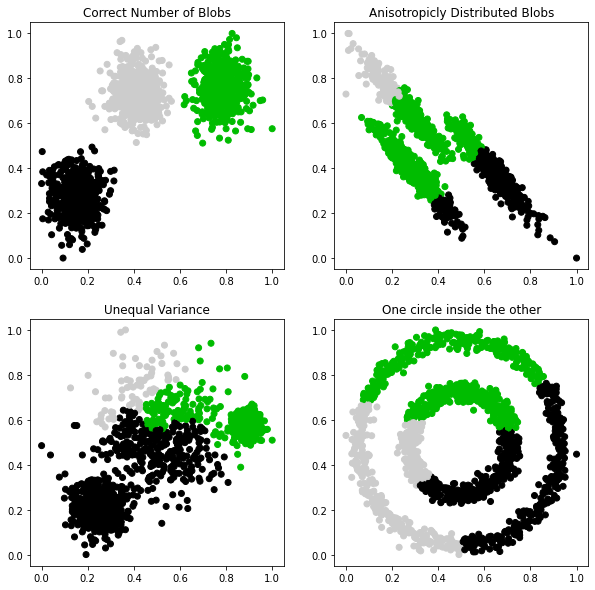

In [23]:
plot_2d_examples(AgglomerativeClustering(n_clusters=3, linkage="complete"))

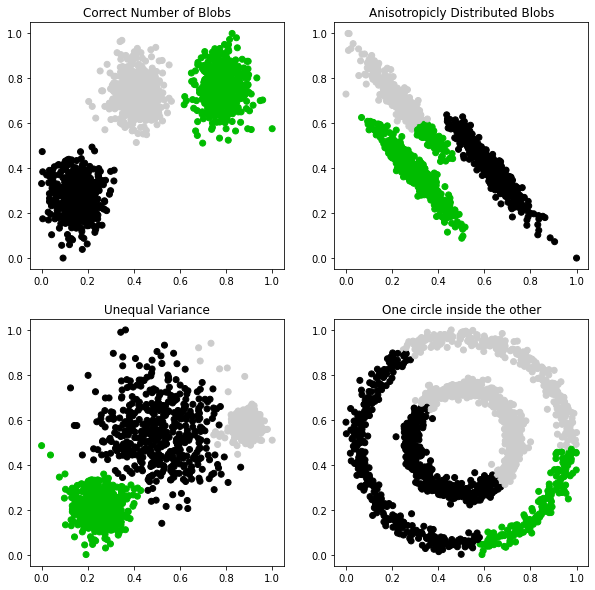

In [24]:
plot_2d_examples(AgglomerativeClustering(n_clusters=3, linkage="average"))

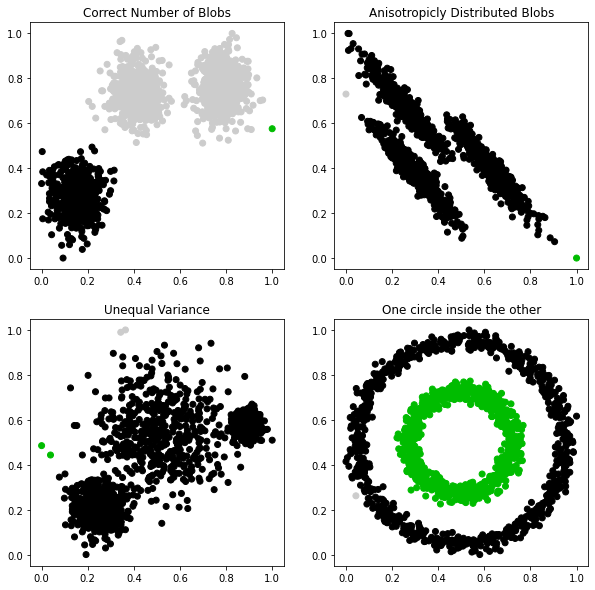

In [25]:
plot_2d_examples(AgglomerativeClustering(n_clusters=3, linkage="single"))

# Homework #5  (Due date: 3rd of August, 23:59)
- Download the Mall Customer Segmentation Data from our github repo.
- Use only 3 features (Age, Income and Spending Score) and run k-means algorithm. Determine/choose the optimum "k" value using the elbow method. Show your plot (error vs. k)
- Again with the same 3 features, scatter your data in a 3D plot. Coloring of samples should denote the determined categories (your optimum k). I.e. we should be able to distinguish the samples of k categories. 

In [26]:
import pandas as pd
!git clone https://github.com/UMBC-Data-Science/DATA602Datasets.git
df = pd.read_csv("./DATA602Datasets/Mall_Customers.csv")
df.head(3)

Cloning into 'DATA602Datasets'...
remote: Enumerating objects: 72, done.
remote: Total 72 (delta 0), reused 0 (delta 0), pack-reused 72
Unpacking objects: 100% (72/72), done.


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6


using only 3 features from mall customer segmentation data and running the k means algorithm

In [27]:
df1=df[['Age','Annual Income (k$)','Spending Score (1-100)']]

In [28]:
df1

,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40
...,...,...,...
195,35,120,79
196,45,126,28
197,32,126,74
198,32,137,18


fitting the data to the k means algorithm

In [29]:
X=df1
kmeans.fit(X)

KMeans(n_clusters=9)

In [30]:
y_kmeans=kmeans.fit_predict(X)

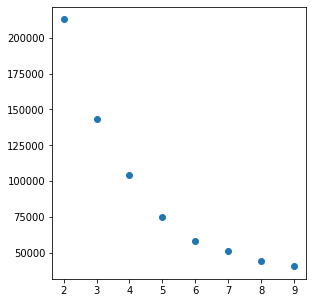

In [31]:
scores = []

for k in range(2, 10):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(df1)
  scores.append( -kmeans.score(df1) )
  
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot([k for k in range(2,10)], scores, 'o')
plt.show()

from the above fig,the optimum value of k is 6.

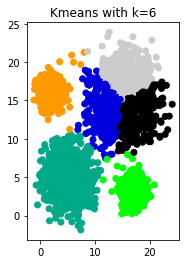

In [32]:
n_clusters=6
y_pred = KMeans(n_clusters=n_clusters).fit_predict(dataset1)

plt.subplot(122)
plt.scatter(dataset1[:, 0], dataset1[:, 1], c=y_pred, cmap=plt.cm.nipy_spectral)
plt.title("Kmeans with k=" + str(n_clusters))

plt.show()

In [42]:
df1["k_value"] = y_kmeans
df1

,Age,Annual Income (k$),Spending Score (1-100),label,k_value
0,19,15,39,8,8
1,21,15,81,4,4
2,20,16,6,5,5
3,23,16,77,4,4
4,31,17,40,8,8
...,...,...,...,...,...
195,35,120,79,0,0
196,45,126,28,6,6
197,32,126,74,0,0
198,32,137,18,6,6


plotting the 3D plot for the obtained optimum kvalue.

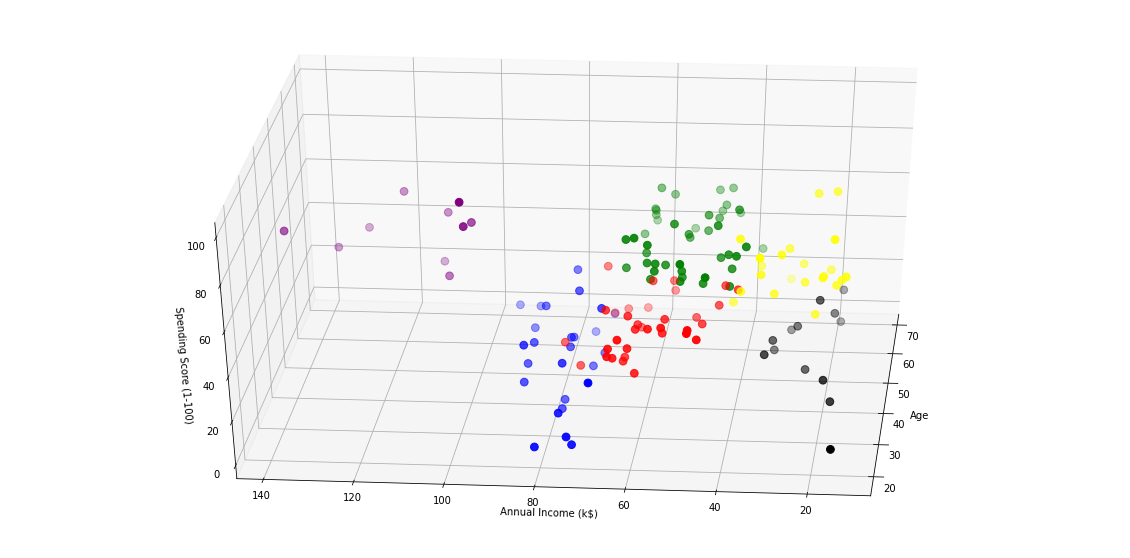

In [43]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df1.Age[df1.k_value == 0], df1["Annual Income (k$)"][df1.k_value == 0], df1["Spending Score (1-100)"][df1.k_value == 0], c='purple', s=60)
ax.scatter(df1.Age[df1.k_value == 1], df1["Annual Income (k$)"][df1.k_value == 1], df1["Spending Score (1-100)"][df1.k_value== 1], c='red', s=60)
ax.scatter(df1.Age[df1.k_value== 2], df1["Annual Income (k$)"][df1.k_value == 2], df1["Spending Score (1-100)"][df1.k_value == 2], c='blue', s=60)
ax.scatter(df1.Age[df1.k_value == 3], df1["Annual Income (k$)"][df1.k_value== 3], df1["Spending Score (1-100)"][df1.k_value== 3], c='green', s=60)
ax.scatter(df1.Age[df1.k_value == 4], df1["Annual Income (k$)"][df1.k_value == 4], df1["Spending Score (1-100)"][df1.k_value== 4], c='yellow', s=60)
ax.scatter(df1.Age[df1.k_value == 5], df1["Annual Income (k$)"][df1.k_value == 5], df1["Spending Score (1-100)"][df1.k_value== 5], c='black', s=60)
ax.view_init(35, 185)
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")
ax.set_zlabel('Spending Score (1-100)')
plt.show()

ref:
1.https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/#:~:text=Elbow%20Method,-In%20the%20Elbow&text=WCSS%20is%20the%20sum%20of,is%20largest%20when%20K%20%3D%201
2.https://medium.com/@budisumandra/mall-customers-segmentation-with-k-means-clustering-algorithm-in-python-55ba10e4bbe3
3.https://www.kaggle.com/code/naren3256/kmeans-clustering-and-cluster-visualization-in-3d/notebook